# Assignment #3: Face Recognition Pipeline
You need to implement a face recognition pipeline and
evaluate it through three stages:
- face detection,
- recognition of whole images,
- recognition of detected faces (this is face recognition
    pipeline evaluation).

## 1. Face detection
- Use the Viola-Jones algorithm for face detection.
- Optimize its parameters for the best performance on the training part of the dataset.
- Report detection metrics using Intersection over Union (IoU).

In [ ]:
import cv2
import os
import pandas as pd
from collections import defaultdict

input_folder = 'CelebA-HQ-small'
csv_path = 'CelebA-HQ-small.csv'

# Load the Haar cascade for face detection (pre-trained model)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the CSV file into a pandas DataFrame, which contains image and bounding box information
df = pd.read_csv(csv_path)

# Filter the dataset to only include the "train" set for training purposes
df = df[df['split'] == 'train']

# Initialize a dictionary to track Intersection-over-Union (IoU) results for each parameter set
iou_results = defaultdict(list)

# Function to calculate Intersection-over-Union (IoU) between two bounding boxes
def calculate_iou(box1, box2):
    # Extract coordinates and dimensions from both boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate intersection coordinates
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    
    # Compute intersection area
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    # Compute areas of both boxes
    box1_area, box2_area = w1 * h1, w2 * h2
    
    # Calculate union area
    union_area = box1_area + box2_area - inter_area
    
    # Return IoU score (intersection area / union area)
    return inter_area / union_area if union_area != 0 else 0

# Iterate through each image in the training set
for _, row in df.iterrows():
    filename = f"{row['idx']}.jpg"  # Construct filename from the dataset index
    image_path = os.path.join(input_folder, filename)  # Build full image path

    # Read the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")
        continue  # Skip if the image fails to load

    # Convert the image to grayscale (required by the Haar Cascade)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get the ground truth bounding box coordinates from the dataset
    ground_truth_box = (row['x_1'], row['y_1'], row['width'], row['height'])

    # Test various parameter combinations for face detection (scaleFactor, minNeighbors, minSize)
    for scaleFactor in [1.01, 1.03, 1.05, 1.08, 1.1]:
        for minNeighbors in [3, 5, 7, 9, 11]:
            for minSize in [(400, 400), (450, 450), (500, 500), (550, 550), (600, 600)]:
                # Perform face detection using the current parameter set
                faces = face_cascade.detectMultiScale(
                    gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=minSize
                )

                # If exactly one face is detected, calculate IoU with the ground truth
                if len(faces) == 1:
                    detected_box = faces[0]
                    iou = calculate_iou(detected_box, ground_truth_box)
                else:
                    iou = 0  # If no face or multiple faces detected, IoU is set to 0

                # Log IoU for the current parameter set (scaleFactor, minNeighbors, minSize)
                key = (scaleFactor, minNeighbors, minSize)
                iou_results[key].append(iou)

# Calculate the average IoU for each parameter set by averaging the values
average_ious = {
    key: sum(values) / len(values) if values else 0
    for key, values in iou_results.items()
}

# Find the best parameter set (highest average IoU)
best_parameters, best_iou = max(average_ious.items(), key=lambda x: x[1])

# Print the best parameters and their corresponding average IoU score
print("\n[SUMMARY] Best Global Parameters Found:")
print(f"Scale Factor: {best_parameters[0]}")
print(f"Min Neighbors: {best_parameters[1]}")
print(f"Min Size: {best_parameters[2]}")
print(f"Average IoU Score: {best_iou}")

# Save the best parameters and IoU score to a log file for future reference
with open('global_best_parameters_log.txt', 'w') as log_file:
    log_file.write("[SUMMARY] Best Global Parameters Found:\n")
    log_file.write(f"Scale Factor: {best_parameters[0]}\n")
    log_file.write(f"Min Neighbors: {best_parameters[1]}\n")
    log_file.write(f"Min Size: {best_parameters[2]}\n")
    log_file.write(f"Average IoU Score: {best_iou}\n")

# Confirm completion and that results have been saved
print("Parameter optimization completed and results saved.")

In [ ]:
import cv2
import os
import pandas as pd

input_folder = 'CelebA-HQ-small' 
csv_path = 'CelebA-HQ-small.csv'

# Load the Haar cascade for face detection (pre-trained model)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the CSV file into a pandas DataFrame, which contains image and bounding box information
df = pd.read_csv(csv_path)

# Filter the dataset to only include the "test" set (testing images)
test_df = df[df['split'] == 'test']

# Set optimal parameters for face detection (these values should be the result of parameter tuning from the previous script)
optimal_scaleFactor = 1.03
optimal_minNeighbors = 5
optimal_minSize = (550, 550)

# Function to calculate Intersection-over-Union (IoU) between two bounding boxes
def calculate_iou(box1, box2):
    # Extract coordinates and dimensions from both boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate intersection coordinates
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    
    # Compute intersection area
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    # Compute areas of both boxes
    box1_area, box2_area = w1 * h1, w2 * h2
    
    # Calculate union area
    union_area = box1_area + box2_area - inter_area
    
    # Return IoU score (intersection area / union area)
    return inter_area / union_area if union_area != 0 else 0

# Initialize a list to log IoU values for each image in the test set
ious = []

# Iterate through each image in the test set to evaluate face detection performance
for _, row in test_df.iterrows():
    # Construct filename from the dataset index
    filename = f"{row['idx']}.jpg"
    image_path = os.path.join(input_folder, filename)  # Build full image path

    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Check if the image was loaded successfully
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")
        continue  # Skip this image if loading fails

    # Convert the image to grayscale (required by the Haar Cascade)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform face detection using the optimal parameters
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=optimal_scaleFactor,
        minNeighbors=optimal_minNeighbors,
        minSize=optimal_minSize
    )

    # If exactly one face is detected, calculate the IoU with the ground truth bounding box
    if len(faces) == 1:
        detected_box = faces[0]  # Detected face bounding box
        ground_truth_box = (row['x_1'], row['y_1'], row['width'], row['height'])  # Ground truth bounding box from CSV
        iou = calculate_iou(detected_box, ground_truth_box)  # Compute IoU between detected and ground truth boxes
        ious.append(iou)  # Store the IoU for this image
    else:
        ious.append(0)  # If no face or multiple faces detected, IoU is set to 0 for this image

# Calculate average IoU across all test images
average_iou = sum(ious) / len(ious) if ious else 0

# Print the average IoU score for the test set
print(f"\n[SUMMARY] Average IoU on Test Set: {average_iou:.4f}")

# Save the results to a log file for future reference
with open('test_set_iou_results.txt', 'w') as log_file:
    log_file.write("[SUMMARY] IoU Results on Test Set:\n")
    log_file.write(f"Average IoU: {average_iou:.4f}\n")  # Log the average IoU
    log_file.write("IoU for each image:\n")  # Log IoU for each individual image
    for idx, iou in enumerate(ious):
        log_file.write(f"Image {test_df.iloc[idx]['idx']}: IoU = {iou:.4f}\n")  # Log individual IoU values

# Confirm completion and that results have been saved to file
print("Test set IoU calculation completed and results saved.")


In [ ]:
import cv2
import os
import pandas as pd

input_folder = 'CelebA-HQ-small'
csv_path = 'CelebA-HQ-small.csv'

# Load the Haar cascade for face detection (pre-trained model)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the CSV file into a pandas DataFrame, which contains image and bounding box information
df = pd.read_csv(csv_path)

# Set the dataframe to include both train and test sets (since it's combined)
test_df = df  # Using the entire dataset, can be split into train/test if necessary

# Set optimal parameters for face detection (these values should be the result of parameter tuning from the previous script)
optimal_scaleFactor = 1.03
optimal_minNeighbors = 5
optimal_minSize = (550, 550)

# Function to calculate Intersection-over-Union (IoU) between two bounding boxes
def calculate_iou(box1, box2):
    # Extract coordinates and dimensions from both boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate intersection coordinates
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    
    # Compute intersection area
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    # Compute areas of both boxes
    box1_area, box2_area = w1 * h1, w2 * h2
    
    # Calculate union area
    union_area = box1_area + box2_area - inter_area
    
    # Return IoU score (intersection area / union area)
    return inter_area / union_area if union_area != 0 else 0

# Initialize a list to log IoU values for each image in the test set
ious = []

# Iterate through each image in the test set to evaluate face detection performance
for _, row in test_df.iterrows():
    # Construct filename from the dataset index
    filename = f"{row['idx']}.jpg"
    image_path = os.path.join(input_folder, filename)  # Build full image path

    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Check if the image was loaded successfully
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")
        continue  # Skip this image if loading fails

    # Convert the image to grayscale (required by the Haar Cascade)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform face detection using the optimal parameters
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=optimal_scaleFactor,
        minNeighbors=optimal_minNeighbors,
        minSize=optimal_minSize
    )

    # If exactly one face is detected, calculate the IoU with the ground truth bounding box
    if len(faces) == 1:
        detected_box = faces[0]  # Detected face bounding box
        ground_truth_box = (row['x_1'], row['y_1'], row['width'], row['height'])  # Ground truth bounding box from CSV
        iou = calculate_iou(detected_box, ground_truth_box)  # Compute IoU between detected and ground truth boxes
        ious.append(iou)  # Store the IoU for this image
    else:
        ious.append(0)  # If no face or multiple faces detected, IoU is set to 0 for this image

# Calculate average IoU across all images in the test set
average_iou = sum(ious) / len(ious) if ious else 0

# Print the average IoU score for the test set
print(f"\n[SUMMARY] Average IoU on Both Sets: {average_iou:.4f}")

# Save the results to a log file for future reference
with open('both_sets_iou_results.txt', 'w') as log_file:
    log_file.write("[SUMMARY] IoU Results on Both Sets:\n")
    log_file.write(f"Average IoU: {average_iou:.4f}\n")  # Log the average IoU
    log_file.write("IoU for each image:\n")  # Log IoU for each individual image
    for idx, iou in enumerate(ious):
        log_file.write(f"Image {test_df.iloc[idx]['idx']}: IoU = {iou:.4f}\n")  # Log individual IoU values

# Confirm completion and that results have been saved to file
print("IoU calculation completed and results saved.")


## 2. Feature Extraction
- Select and implement at least three feature extraction methods for face recognition. You may use implementations available in popular libraries (e.g., Scikit-learn, OpenCV).
- Probably the easiest to use methods:
    - Local Binary Patterns (LBP),
    - Histogram of Oriented Gradients (HOG),
    - Dense SIFT (using a fixed grid instead of keypoint detectors).

In [11]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler

# 1. Local Binary Patterns (LBP)
def extract_lbp_features(image, radius=1, n_points=8):
    """
    Extract Local Binary Patterns (LBP) features from the input image.
    
    Parameters:
        image (numpy.ndarray): The input image (BGR).
        radius (int): The radius of the circular neighborhood.
        n_points (int): The number of sampling points in the circular neighborhood.
    
    Returns:
        lbp_hist (numpy.ndarray): The normalized histogram of LBP features.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply LBP to the grayscale image
    lbp = local_binary_pattern(gray, n_points * radius, radius, method='uniform')
    
    # Get the number of bins for the histogram (based on the maximum LBP value)
    n_bins = int(lbp.max() + 1)
    
    # Compute the LBP histogram
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
    
    # Normalize the histogram to ensure the sum equals 1 (for better comparison across images)
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)  # Small constant to avoid division by zero
    
    return lbp_hist

# 2. Histogram of Oriented Gradients (HOG)
def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """
    Extract Histogram of Oriented Gradients (HOG) features from the input image.
    
    Parameters:
        image (numpy.ndarray): The input image (BGR).
        pixels_per_cell (tuple): The size of each cell (height, width).
        cells_per_block (tuple): The number of cells per block (height, width).
    
    Returns:
        features (numpy.ndarray): The HOG feature vector.
    """
    # Convert the image to grayscale if it has more than one channel (BGR image)
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features from the image
    features = hog(
        image,  # Input grayscale image
        orientations=9,  # Number of gradient bins
        pixels_per_cell=pixels_per_cell,  # Size of each cell
        cells_per_block=cells_per_block,  # Number of cells per block
        block_norm='L2-Hys',  # Block normalization type
        visualize=False  # Don't visualize the HOG image (just return features)
    )
    
    return features

# 3. Dense SIFT
def extract_dense_sift_features(image, step_size=8):
    """
    Extract Dense Scale-Invariant Feature Transform (SIFT) features from the input image.
    
    Parameters:
        image (numpy.ndarray): The input image (BGR).
        step_size (int): The distance between keypoints in the dense grid (higher = sparser keypoints).
    
    Returns:
        descriptors_flat (numpy.ndarray): The flattened array of SIFT descriptors.
    """
    # Convert the image to grayscale (SIFT works on single-channel images)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a SIFT detector object
    sift = cv2.SIFT_create()
    
    # Create a dense grid of keypoints, with a step size determining the grid spacing
    keypoints = [
        cv2.KeyPoint(x, y, step_size)  # Generate keypoints at each grid position
        for y in range(0, gray.shape[0], step_size)  # Loop through image rows with step size
        for x in range(0, gray.shape[1], step_size)  # Loop through image columns with step size
    ]
    
    # Compute SIFT descriptors for the keypoints
    keypoints, descriptors = sift.compute(gray, keypoints)
    
    # If no descriptors are found (i.e., descriptors is None), return an empty array
    if descriptors is None:
        return np.array([])  # Handle cases where no keypoints are found
    
    # Flatten the list of descriptors to create a single feature vector
    return descriptors.flatten()


## 3. Evaluation through three experiments
- (I) Evaluate detection performance separately and report IoU metrics.
- Evaluate recognition performance. Plot Cumulative Match Characteristic (CMC) curves and report Rank-1 and Rank-5 recognition accuracies:
    - (II) Whole images using each feature extractor,
    - (III) The full pipeline (Viola-Jones for detection followed by each feature extractor).

In [28]:
import cv2
import pandas as pd
import os

# Set paths
input_folder = 'CelebA-HQ-small'
csv_path = 'CelebA-HQ-small.csv'  # Path to the CSV file containing the metadata

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)  # Read the CSV that contains image metadata (e.g., 'idx', 'identity', etc.)

# Filter only the "test" set from the CSV
test_df = df[df['split'] == 'test']  # Select rows where the 'split' column is marked as 'test'

# Initialize dictionaries for storing extracted features from each image
lbp_features = {}  # Dictionary to store LBP features for each image
sift_features = {}  # Dictionary to store Dense SIFT features for each image
hog_features = {}  # Dictionary to store HOG features for each image

# Iterate through each image in the test set
for _, row in test_df.iterrows():  # Loop through each row in the filtered test set DataFrame
    filename = f"{row['idx']}.jpg"  # Construct the image filename using the 'idx' column
    label = row['identity']  # Get the label (identity) for the image
    image_path = os.path.join(input_folder, filename)  # Construct the full path to the image

    # Read the image from the disk
    image = cv2.imread(image_path)  # Open the image using OpenCV
    
    # Skip the image if it fails to load (e.g., if the file is missing or corrupted)
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")  # Print an error message
        continue  # Skip this iteration and move to the next image
    
    if row["idx"] in lbp_features:
        print(f"Skipping image {row['idx']} as features already extracted.")

    # Extract features using previously defined functions
    lbp_feat = extract_lbp_features(image)  # Extract LBP features (assumes this function is defined elsewhere)
    sift_feat = extract_dense_sift_features(image)  # Extract Dense SIFT features (assumes this function is defined elsewhere)
    hog_feat = extract_hog_features(image)  # Extract HOG features (assumes this function is defined elsewhere)

    # Save the extracted features along with their labels into the dictionaries
    lbp_features[row['idx']] = {'label': label, 'features': lbp_feat.tolist()}  # Store LBP features for this image
    sift_features[row['idx']] = {'label': label, 'features': sift_feat.tolist()}  # Store SIFT features for this image
    hog_features[row['idx']] = {'label': label, 'features': hog_feat.tolist()}  # Store HOG features for this image


Skipping image 1205 as features already extracted.
Skipping image 5389 as features already extracted.
Skipping image 6622 as features already extracted.
Skipping image 7311 as features already extracted.
Skipping image 10666 as features already extracted.
Skipping image 13261 as features already extracted.
Skipping image 18530 as features already extracted.
Skipping image 19817 as features already extracted.
Skipping image 19932 as features already extracted.
Skipping image 21727 as features already extracted.
Skipping image 24919 as features already extracted.
Skipping image 25532 as features already extracted.
Skipping image 25532 as features already extracted.
Skipping image 25532 as features already extracted.
Skipping image 28343 as features already extracted.
Skipping image 28733 as features already extracted.
Skipping image 28733 as features already extracted.


LBP - Rank-1 Accuracy: 4.05%
LBP - Rank-5 Accuracy: 21.01%
HOG - Rank-1 Accuracy: 15.19%
HOG - Rank-5 Accuracy: 38.73%
SIFT - Rank-1 Accuracy: 26.58%
SIFT - Rank-5 Accuracy: 50.38%


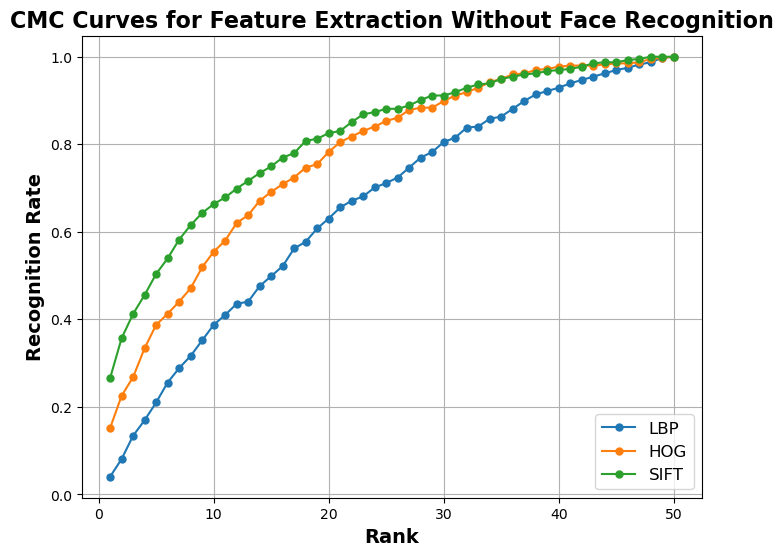

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def parse_features(data):
    """Extract features and labels from the given data dictionary."""
    features = []
    labels = []
    for idx, info in data.items():
        features.append(info['features'])
        labels.append(info['label'])
    return np.array(features), np.array(labels)

def calculate_similarity_matrix(features):
    """Calculate the cosine similarity matrix."""
    # Normalize features
    normalized_features = features / np.linalg.norm(features, axis=1, keepdims=True)
    # Compute pairwise cosine similarity
    similarity_matrix = np.dot(normalized_features, normalized_features.T)
    return similarity_matrix

def create_n_by_c_matrix(similarity_matrix, labels):
    """Transform similarity matrix to n x c matrix."""
    n = similarity_matrix.shape[0]
    unique_classes = np.unique(labels)
    c = len(unique_classes)
    
    # Map identities to column indices
    class_to_indices = {cls: np.where(labels == cls)[0] for cls in unique_classes}
    n_by_c_matrix = np.full((n, c), np.inf)
    
    # Fill the matrix with minimum dissimilarity values (1 - similarity)
    for i in range(n):
        for j, cls in enumerate(unique_classes):
            class_indices = class_to_indices[cls]
            valid_indices = [idx for idx in class_indices if idx != i]
            if valid_indices:
                n_by_c_matrix[i, j] = 1 - np.max(similarity_matrix[i, valid_indices])
    
    return n_by_c_matrix, unique_classes

def compute_ranks_and_cmc(n_by_c_matrix, true_labels, unique_classes):
    """Compute ranks and CMC for the dataset."""
    n, c = n_by_c_matrix.shape
    class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
    ranks = np.zeros(n)
    
    for i in range(n):
        sorted_indices = np.argsort(n_by_c_matrix[i])  # Sort classes by similarity (ascending)
        sorted_classes = unique_classes[sorted_indices]
        true_class_index = class_to_index[true_labels[i]]
        ranks[i] = np.where(sorted_classes == true_labels[i])[0][0]  # Rank of the correct class

    cmc = np.zeros(c)
    for z in range(c):
        cmc[z] = np.sum(ranks <= z) / n  # Fraction of queries with rank <= z
    
    return ranks, cmc

def plot_cmc_curve(cmc_dict):
    """Plot the CMC curves for multiple feature types."""
    plt.figure(figsize=(8, 6))
    for feature_type, cmc in cmc_dict.items():
        plt.plot(np.arange(1, len(cmc) + 1), cmc, marker='o', label=feature_type, markersize=5, linewidth=1.5)
    plt.title('CMC Curves for Feature Extraction Without Face Recognition', fontsize=16, fontweight='bold')
    plt.xlabel('Rank', fontsize=14, fontweight='bold')
    plt.ylabel('Recognition Rate', fontsize=14, fontweight='bold')
    plt.grid(True)
    plt.legend(loc='lower right', fontsize=12)
    plt.savefig("fullimagecmc.pdf", format='pdf')
    plt.show()

# Process each dataset and compute CMC
datasets = {"LBP": lbp_features, "HOG": hog_features, "SIFT": sift_features}
cmc_results = {}

for feature_type, data in datasets.items():
    features, labels = parse_features(data)
    similarity_matrix = calculate_similarity_matrix(features)
    n_by_c_matrix, unique_classes = create_n_by_c_matrix(similarity_matrix, labels)
    ranks, cmc = compute_ranks_and_cmc(n_by_c_matrix, labels, unique_classes)
    
    # Store CMC curve for plotting
    cmc_results[feature_type] = cmc

    # Print Rank-1 and Rank-5 for this feature type
    rank_1 = np.sum(ranks == 0) / len(ranks)
    rank_5 = np.sum(ranks <= 4) / len(ranks)
    print(f"{feature_type} - Rank-1 Accuracy: {rank_1 * 100:.2f}%")
    print(f"{feature_type} - Rank-5 Accuracy: {rank_5 * 100:.2f}%")

# Plot all CMC curves on one graph
plot_cmc_curve(cmc_results)



In [40]:
import cv2
import pandas as pd
import os

# Set paths for the dataset and CSV
input_folder = 'CelebA-HQ-small'  # Folder containing the images
csv_path = 'CelebA-HQ-small.csv'  # CSV file containing metadata about the images

# Load the Haar cascade for face detection (Viola-Jones algorithm)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the CSV file into a DataFrame for easy access to the image information
df = pd.read_csv(csv_path)

# Filter only the images from the "test" set
test_df = df[df['split'] == 'test']

# Set optimal parameters for face detection (can be adjusted based on previous experiments)
optimal_scaleFactor = 1.03  # Factor by which the image size is reduced at each image scale
optimal_minNeighbors = 5    # Minimum number of neighbors for the face detection to be considered valid
optimal_minSize = (550, 550)  # Minimum size of the face to be detected

# Iterate through each image in the test set
for _, row in test_df.iterrows():
    filename = f"{row['idx']}.jpg"  # Get the image filename using the index from the CSV
    image_path = os.path.join(input_folder, filename)  # Construct the full image path

    image = cv2.imread(image_path)  # Read the image using OpenCV
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")  # Handle missing or unreadable images
        continue

    # Convert the image to grayscale for face detection (Viola-Jones works on grayscale images)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform face detection using the Haar cascade with the set optimal parameters
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=optimal_scaleFactor,
        minNeighbors=optimal_minNeighbors,
        minSize=optimal_minSize
    )
    
    # If exactly one face is detected, crop and resize it to 512x512
    if len(faces) == 1:
        x, y, w, h = faces[0]  # Get the coordinates and size of the detected face
        face = image[y:y+h, x:x+w]  # Crop the face region from the image
        resized_face = cv2.resize(face, (512, 512))  # Resize the cropped face to 512x512 pixels
        
        # Save the resized face image to the 'resized_faces' folder
        output_folder = 'resized_faces'
        os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist
        output_path = os.path.join(output_folder, filename)  # Construct the output file path
        cv2.imwrite(output_path, resized_face)  # Save the resized face image
    else:
        resized_face = None  # If no face or multiple faces detected, skip saving the face


In [41]:
import cv2
import pandas as pd
import os

# Set paths for the resized face images
input_folder = 'resized_faces'  # Path where resized face images are stored (generated from previous step)

# Load the CSV file containing metadata into a DataFrame (make sure csv_path is defined before)
df = pd.read_csv(csv_path)  # Load CSV that contains image metadata (like labels and splits)

# Filter the DataFrame to only include the "test" set (images for evaluation)
test_df = df[df['split'] == 'test']

# Initialize dictionaries to store the extracted features for each image
lbp_features = {}  # Local Binary Patterns (LBP) features
sift_features = {}  # SIFT features
hog_features = {}  # Histogram of Oriented Gradients (HOG) features

# Iterate through each image in the "test" set
for _, row in test_df.iterrows():
    filename = f"{row['idx']}.jpg"  # Get the filename from the index column in CSV
    label = row['identity']  # Get the label (identity) from the row
    image_path = os.path.join(input_folder, filename)  # Construct the full path for the image file

    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")  # If image cannot be read, print error and skip
        continue

    # Extract features from the image using different methods
    lbp_feat = extract_lbp_features(image)  # Local Binary Pattern (LBP) feature extraction (function to be defined)
    sift_feat = extract_dense_sift_features(image)  # SIFT feature extraction (function to be defined)
    hog_feat = extract_hog_features(image)  # HOG feature extraction (function to be defined)

    # Store the extracted features in the dictionaries with their respective label
    lbp_features[row['idx']] = {'label': label, 'features': lbp_feat.tolist()}  # Store LBP features
    sift_features[row['idx']] = {'label': label, 'features': sift_feat.tolist()}  # Store SIFT features
    hog_features[row['idx']] = {'label': label, 'features': hog_feat.tolist()}  # Store HOG features

# Print feature summaries (optional) for the first image in the dictionary
print(f"LBP Features for first image: {list(lbp_features.items())[0]}")  # Print LBP features of the first image
print(f"SIFT Features for first image: {list(sift_features.items())[0]}")  # Print SIFT features of the first image
print(f"HOG Features for first image: {list(hog_features.items())[0]}")  # Print HOG features of the first image


[ERROR] Failed to load 3561.jpg. Skipping.


[ WARN:0@9297.446] global loadsave.cpp:241 findDecoder imread_('resized_faces/3561.jpg'): can't open/read file: check file path/integrity


[ERROR] Failed to load 6557.jpg. Skipping.


[ WARN:0@9302.427] global loadsave.cpp:241 findDecoder imread_('resized_faces/6557.jpg'): can't open/read file: check file path/integrity
[ WARN:0@9307.914] global loadsave.cpp:241 findDecoder imread_('resized_faces/10380.jpg'): can't open/read file: check file path/integrity


[ERROR] Failed to load 10380.jpg. Skipping.
[ERROR] Failed to load 20190.jpg. Skipping.


[ WARN:0@9320.329] global loadsave.cpp:241 findDecoder imread_('resized_faces/20190.jpg'): can't open/read file: check file path/integrity


[ERROR] Failed to load 21555.jpg. Skipping.


[ WARN:0@9322.446] global loadsave.cpp:241 findDecoder imread_('resized_faces/21555.jpg'): can't open/read file: check file path/integrity


[ERROR] Failed to load 22854.jpg. Skipping.


[ WARN:0@9323.833] global loadsave.cpp:241 findDecoder imread_('resized_faces/22854.jpg'): can't open/read file: check file path/integrity


[ERROR] Failed to load 23906.jpg. Skipping.


[ WARN:0@9325.616] global loadsave.cpp:241 findDecoder imread_('resized_faces/23906.jpg'): can't open/read file: check file path/integrity


[ERROR] Failed to load 24255.jpg. Skipping.


[ WARN:0@9326.016] global loadsave.cpp:241 findDecoder imread_('resized_faces/24255.jpg'): can't open/read file: check file path/integrity


[ERROR] Failed to load 25843.jpg. Skipping.


[ WARN:0@9328.608] global loadsave.cpp:241 findDecoder imread_('resized_faces/25843.jpg'): can't open/read file: check file path/integrity


[ERROR] Failed to load 26718.jpg. Skipping.


[ WARN:0@9329.385] global loadsave.cpp:241 findDecoder imread_('resized_faces/26718.jpg'): can't open/read file: check file path/integrity


LBP Features for first image: (123, {'label': 138, 'features': [0.05295562744138605, 0.07894897460934489, 0.06189727783200764, 0.11466979980464376, 0.17313766479485582, 0.12932968139643503, 0.0879745483398102, 0.08410263061520229, 0.08710479736324803, 0.12987899780268483]})
SIFT Features for first image: (123, {'label': 138, 'features': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 24.0, 7.0, 3.0, 1.0, 0.0, 0.0, 0.0, 48.0, 28.0, 4.0, 3.0, 0.0, 0.0, 2.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 160.0, 160.0, 45.0, 7.0, 1.0, 1.0, 4.0, 63.0, 160.0, 160.0, 44.0, 10.0, 1.0, 0.0, 3.0, 150.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 3.0, 2.0, 0.0, 0.0, 1.0, 5.0, 9.0, 160.0, 45.0, 11.0, 1.0, 1.0, 2.0, 11.0, 160.0, 160.0, 70.0, 36.0, 108.0, 21.0, 1.0

LBP - Rank-1 Accuracy: 7.27%
LBP - Rank-5 Accuracy: 25.97%
HOG - Rank-1 Accuracy: 20.52%
HOG - Rank-5 Accuracy: 43.90%
SIFT - Rank-1 Accuracy: 41.04%
SIFT - Rank-5 Accuracy: 65.19%


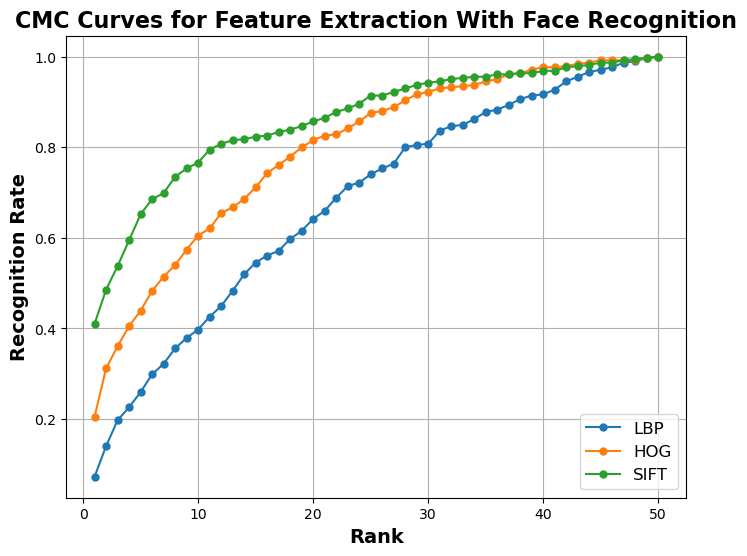

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def parse_features(data):
    """Extract features and labels from the given data dictionary."""
    features = []
    labels = []
    for idx, info in data.items():
        features.append(info['features'])
        labels.append(info['label'])
    return np.array(features), np.array(labels)

def calculate_similarity_matrix(features):
    """Calculate the cosine similarity matrix."""
    # Normalize features
    normalized_features = features / np.linalg.norm(features, axis=1, keepdims=True)
    # Compute pairwise cosine similarity
    similarity_matrix = np.dot(normalized_features, normalized_features.T)
    return similarity_matrix

def create_n_by_c_matrix(similarity_matrix, labels):
    """Transform similarity matrix to n x c matrix."""
    n = similarity_matrix.shape[0]
    unique_classes = np.unique(labels)
    c = len(unique_classes)
    
    # Map identities to column indices
    class_to_indices = {cls: np.where(labels == cls)[0] for cls in unique_classes}
    n_by_c_matrix = np.full((n, c), np.inf)
    
    # Fill the matrix with minimum dissimilarity values (1 - similarity)
    for i in range(n):
        for j, cls in enumerate(unique_classes):
            class_indices = class_to_indices[cls]
            valid_indices = [idx for idx in class_indices if idx != i]
            if valid_indices:
                n_by_c_matrix[i, j] = 1 - np.max(similarity_matrix[i, valid_indices])
    
    return n_by_c_matrix, unique_classes

def compute_ranks_and_cmc(n_by_c_matrix, true_labels, unique_classes):
    """Compute ranks and CMC for the dataset."""
    n, c = n_by_c_matrix.shape
    class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
    ranks = np.zeros(n)
    
    for i in range(n):
        sorted_indices = np.argsort(n_by_c_matrix[i])  # Sort classes by similarity (ascending)
        sorted_classes = unique_classes[sorted_indices]
        true_class_index = class_to_index[true_labels[i]]
        ranks[i] = np.where(sorted_classes == true_labels[i])[0][0]  # Rank of the correct class

    cmc = np.zeros(c)
    for z in range(c):
        cmc[z] = np.sum(ranks <= z) / n  # Fraction of queries with rank <= z
    
    return ranks, cmc

def plot_cmc_curve(cmc_dict):
    """Plot the CMC curves for multiple feature types."""
    plt.figure(figsize=(8, 6))
    for feature_type, cmc in cmc_dict.items():
        plt.plot(np.arange(1, len(cmc) + 1), cmc, marker='o', label=feature_type, markersize=5, linewidth=1.5)
    plt.title('CMC Curves for Feature Extraction With Face Recognition', fontsize=16, fontweight='bold')
    plt.xlabel('Rank', fontsize=14, fontweight='bold')
    plt.ylabel('Recognition Rate', fontsize=14, fontweight='bold')
    plt.grid(True)
    plt.legend(loc='lower right', fontsize=12)
    plt.savefig("pipelineimagecmc.pdf", format='pdf')
    plt.show()

# Process each dataset and compute CMC
datasets = {"LBP": lbp_features, "HOG": hog_features, "SIFT": sift_features}
cmc_results = {}

for feature_type, data in datasets.items():
    features, labels = parse_features(data)
    similarity_matrix = calculate_similarity_matrix(features)
    n_by_c_matrix, unique_classes = create_n_by_c_matrix(similarity_matrix, labels)
    ranks, cmc = compute_ranks_and_cmc(n_by_c_matrix, labels, unique_classes)
    
    # Store CMC curve for plotting
    cmc_results[feature_type] = cmc

    # Print Rank-1 and Rank-5 for this feature type
    rank_1 = np.sum(ranks == 0) / len(ranks)
    rank_5 = np.sum(ranks <= 4) / len(ranks)
    print(f"{feature_type} - Rank-1 Accuracy: {rank_1 * 100:.2f}%")
    print(f"{feature_type} - Rank-5 Accuracy: {rank_5 * 100:.2f}%")

# Plot all CMC curves on one graph
plot_cmc_curve(cmc_results)